In [3]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
# !pip -q install ultralyticsplus==0.0.23 ultralytics==8.0.21 ultralytics pathlib
%pip install -qr requirements.txt comet_ml

import torch
import utils
from pathlib import Path
import os
from PIL import Image
import cv2


Cloning into 'yolov5'...
remote: Enumerating objects: 16057, done.
remote: Total 16057 (delta 0), reused 0 (delta 0), pack-reused 16057
Receiving objects: 100% (16057/16057), 14.60 MiB | 18.08 MiB/s, done.
Resolving deltas: 100% (11032/11032), done.
/content/yolov5/yolov5


In [4]:
!dir

benchmarks.py	 data	     LICENSE	      requirements.txt	tutorial.ipynb
CITATION.cff	 detect.py   models	      segment		utils
classify	 export.py   README.md	      setup.cfg		val.py
CONTRIBUTING.md  hubconf.py  README.zh-CN.md  train.py


In [5]:
custom_weights = '/content/drive/MyDrive/runs/train/exp/weights/best.pt'  # @param {type:"string"}
input_folder = '/content/images/'  # @param {type:"string"}
output_folder = '/content/annotation/' # @param {type:"string"}
expand_box = 1 # @param {type:"raw"}
print_log = False

os.makedirs(output_folder, exist_ok=True)

model = torch.hub.load('ultralytics/yolov5', 'custom', path=custom_weights, force_reload=True)

def adjust_bbox(bbox, expand_factor, img_width, img_height):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    new_width = width * expand_factor
    new_height = height * expand_factor
    new_x1 = max(x1 - (new_width - width) / 2, 0)
    new_y1 = max(y1 - (new_height - height) / 2, 0)
    new_x2 = min(x2 + (new_width - width) / 2, img_width)
    new_y2 = min(y2 + (new_height - height) / 2, img_height)
    return new_x1, new_y1, new_x2, new_y2

for img_path in Path(input_folder).glob('*.*'):
    # Use cv2.imread to read the image
    original_img = cv2.imread(str(img_path))
    if original_img is None:
        continue  # Skip if the image cannot be read

    results = model(original_img)

    img_name = img_path.stem
    txt_name = img_name + ".txt"

    txt_path = os.path.join(output_folder, txt_name)

    img_height, img_width, _ = original_img.shape

    with open(txt_path, 'w') as txt_file:
        for idx, det in enumerate(results.xyxy[0]):
            bbox = adjust_bbox(det[:4].cpu().numpy(), expand_box, img_width, img_height)

            # x_center, y_center, width, height = [(bbox[i] + bbox[i + 2]) / 2 for i in range(4)]

            x_center, y_center, width, height = [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2, bbox[2] - bbox[0], bbox[3] - bbox[1]]
            x_center /= img_width
            y_center /= img_height
            width /= img_width
            height /= img_height

            label_idx = int(det[5])
            label = ["face", "hair", "eye", "hands", "feet", "upper_body", "lower_body"][label_idx]

            line = f"{label_idx} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
            txt_file.write(line)

    if print_log:
        print(f'Processed {img_path}')
        #------------------------------------------------------------ok


/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 267 layers, 46140588 parameters, 0 gradients, 107.7 GFLOPs
Adding AutoShape... 


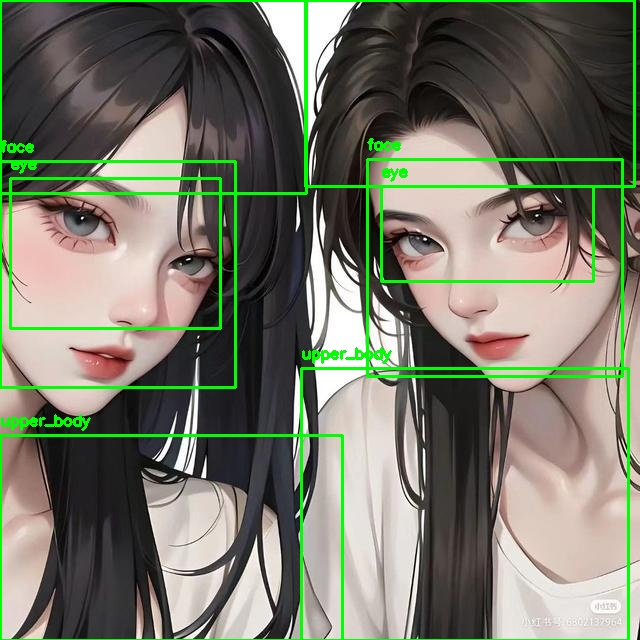

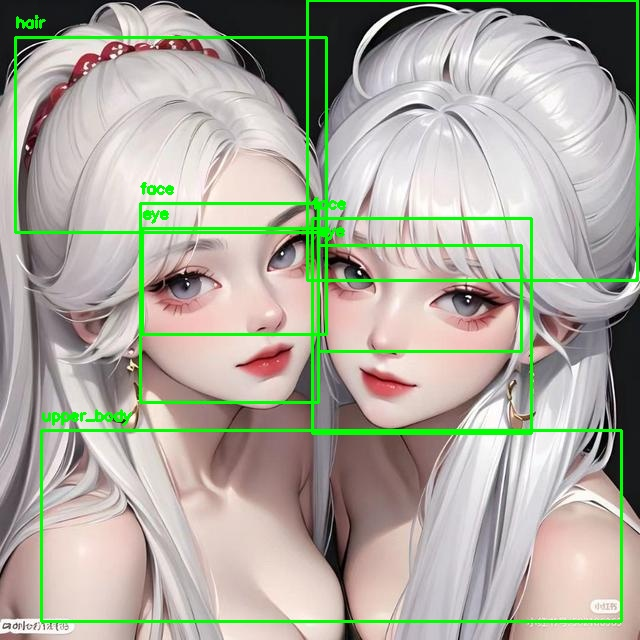

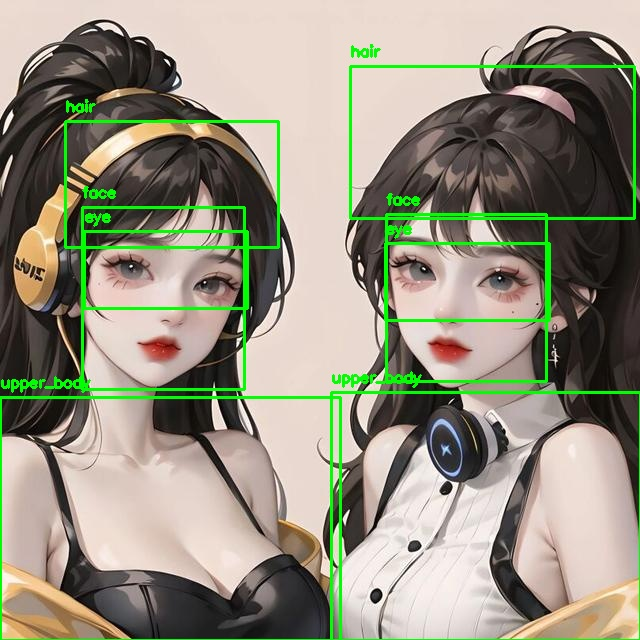

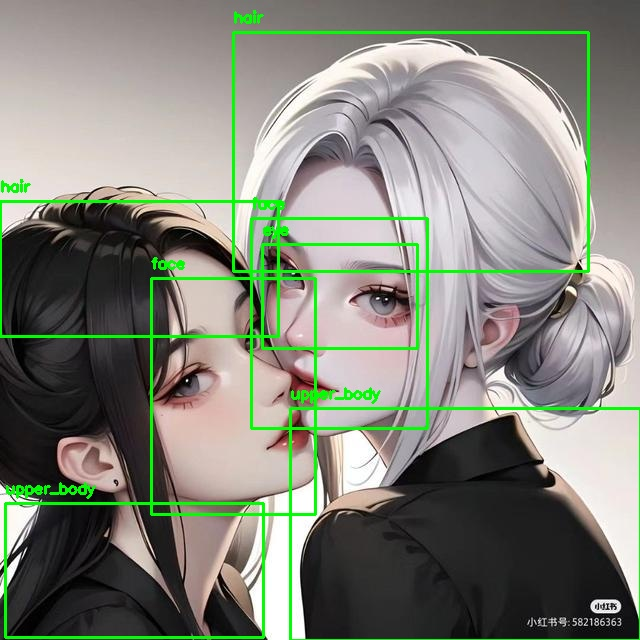

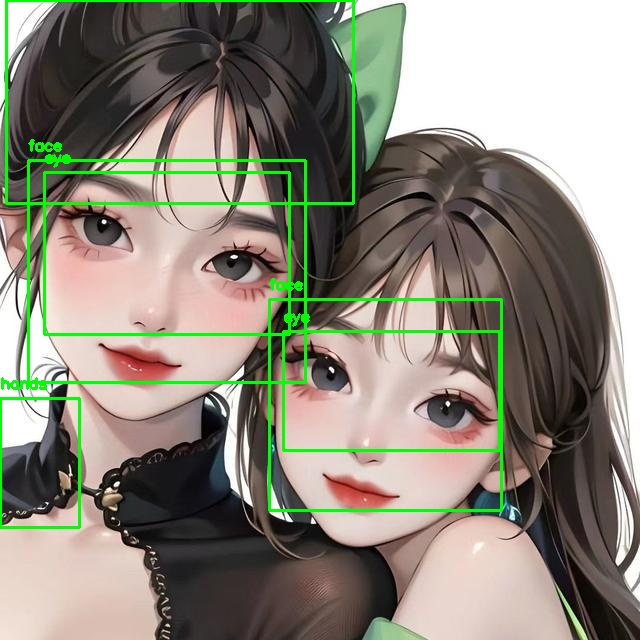

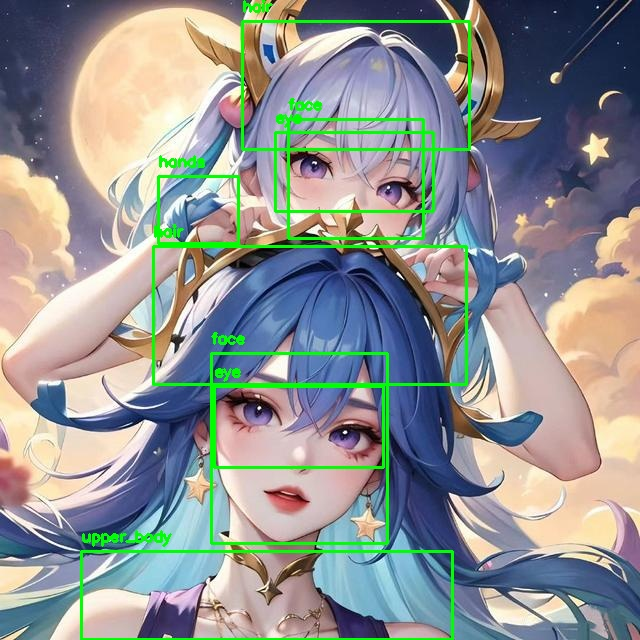

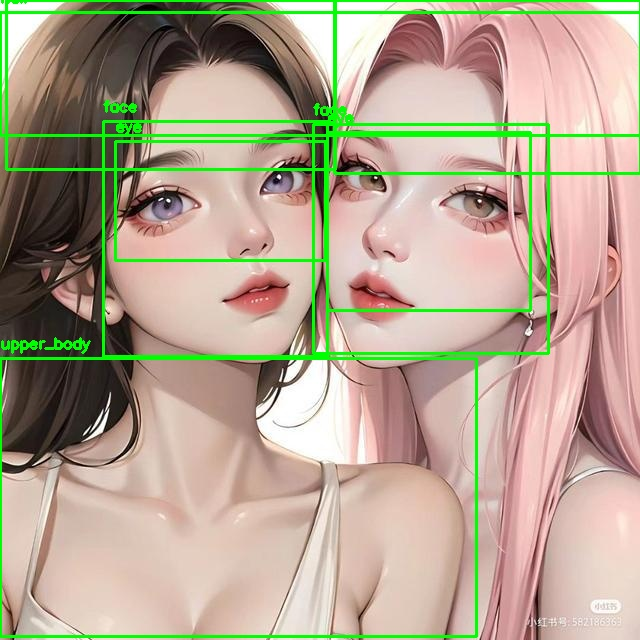

In [6]:
import os
import cv2
from pathlib import Path
from IPython.display import display, Image as IPImage

input_folder = '/content/images/' # @param {type:"string"}
annotation_folder = '/content/annotation/' # @param {type:"string"}

output_folder = '/content/output/' # @param {type:"string"}
os.makedirs(output_folder, exist_ok=True)

labels = ["face", "hair", "eye", "hands", "feet", "upper_body", "lower_body"]

for img_path in Path(input_folder).glob('*.*'):
    img_name = img_path.stem
    txt_path = os.path.join(annotation_folder, f"{img_name}.txt")

    # Skip if there is no annotation file for the image
    if not os.path.exists(txt_path):
        continue

    img = cv2.imread(str(img_path))

    with open(txt_path, 'r') as txt_file:
        for line in txt_file:
            label_idx, x_center, y_center, width, height = map(float, line.split())
            img_width, img_height, _ = img.shape

            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            label_text = labels[int(label_idx)]

            # Draw bounding box on the image
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Add label text
            cv2.putText(img, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Convert BGR image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Save the image with bounding boxes and labels
    output_path = os.path.join(output_folder, f'{img_name}_annotated.jpg')
    cv2.imwrite(output_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))

    # Display the image with bounding boxes and labels
    display(IPImage(output_path))


In [8]:
#@title Download datasets - txt file
import os
from google.colab import files
import shutil

folder_path = "/content/annotation/" # @param {type:"string"}

def zip_and_download_images(folder_path, zip_filename='datasets.zip'):
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} not found.")
        return

    file_list = os.listdir(folder_path)

    temp_folder = '/content/datasets'
    os.makedirs(temp_folder, exist_ok=True)

    for file_name in file_list:
        if file_name.lower().endswith((".txt")):
            file_path = os.path.join(folder_path, file_name)
            shutil.copy(file_path, temp_folder)

    shutil.make_archive(temp_folder, 'zip', temp_folder)

    print(f"Downloading ZIP: {zip_filename}")
    files.download(f'{temp_folder}.zip')

    shutil.rmtree(temp_folder)

zip_and_download_images(folder_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Diffusion Pipeline**

Huggingface: https://huggingface.co/DamarJati

Github: https://github.com/Damarcreative

Instagram: @Damar_shop & @Pixonelab

Mail: dev@damarcreative.my.id

Site: www.damarcreative.my.id

------
